# Hovmoller plots of AMOC strength

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
from dask.distributed import Client
from collections import OrderedDict
import xarray as xr

import IPython.display
import cartopy.crs as ccrs
from xhistogram.xarray import histogram
import pandas as pd



In [2]:
session = cc.database.create_session('/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_experiments_1.db')

In [3]:
expt = '1deg_jra55_ryf_RCPwarmhumid'
variable = 'temp_global_ave'
darray_warm = cc.querying.getvar(expt, variable, session, ncfile = 'ocean_scalar.nc')
darray_warm
annual_average_warm = darray_warm.groupby('time.year').mean(dim='time')
darray_swarm = cc.querying.getvar(expt, 'temp_surface_ave', session)
annual_average_swarm = darray_swarm.groupby('time.year').mean(dim='time')
temp_warm = cc.querying.getvar(expt, 'temp', session, ncfile = 'ocean.nc')
annual_SST_warm = temp_warm.isel(st_ocean = 0).groupby('time.year').mean(dim='time')
surface_heat_flux_warm = cc.querying.getvar(expt,'net_sfc_heating',session)#.groupby('time.year').sum(dim='time')
density_warm = cc.querying.getvar(expt,'pot_rho_2',session).groupby('time.year').sum(dim='time')


In [4]:
    def heatfuncforamoc(ekey,masktrue, mask):
        expt = exptdict[ekey]['expt']

        if masktrue == False:
            psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc')
            psi = psi.sum('grid_xt_ocean')
            
            psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session)
            psiGM = (psiGM).sum('grid_xt_ocean')
            psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session)
            psisubmeso = (psisubmeso).sum('grid_xt_ocean')
            
        else:
            
            psi = cc.querying.getvar(expt,'ty_trans_nrho',session, ncfile = 'ocean.nc')
            psi = psi*mask
            psi = psi.sum('grid_xt_ocean')
            psiGM = cc.querying.getvar(expt,'ty_trans_nrho_gm',session)
            psiGM = (psiGM*mask).sum('grid_xt_ocean')
            psisubmeso = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session)
            psisubmeso = (psisubmeso*mask).sum('grid_xt_ocean')

    
        rho = 1025 # mean density of sea-water in kg/m^3
        psi = psi / (1e6*rho) # converts kg/s to Sv
        psiGM = psiGM / (1e6*rho)
        psisubmeso = psisubmeso / (1e6*rho)

        psi_avg = psi.cumsum('neutral') - psi.sum('neutral')
        psi_avg = psi_avg + psisubmeso
        psi_avg.load()   
    
        rho_0 = 1030#kg/m^3
        c_p = 3992 
        A_I = -rho_0*c_p*psi_avg.cumsum('neutral')*0.5 #(0.5 is size of d\theta)
        A_I = A_I/10**9 # convert to PW
        #A_I_contatlantic= (A_I_contatlantic).where(psi_avg_contatlantic!=0).fillna(0)
        return psi_avg, A_I

In [5]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:43925 Dashboard: /proxy/35039/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [8]:
expt = '1deg_jra55_ryf_RCPcont'
ht = cc.querying.getvar(expt,'ht',session,n=-1)
land_mask = ~ht.isnull()

south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)
south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

psi = cc.querying.getvar(expt,'ty_trans_rho',session, n=1) ## needs to be the same coordinates as what you want to mask
atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
indo_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
indo_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
indo_sector_mask = indo_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})


In [10]:
exptdict = OrderedDict([
    ('Control',  {'expt':'1deg_jra55_ryf_RCPcont'}),
    ('Warming',  {'expt':'1deg_jra55_ryf_RCPwarmhumid'}),
    ('Warming x2',  {'expt':'1deg_jra55_ryf_RCPwarmhumid2x'}),
    ('Cooling',  {'expt':'1deg_jra55_ryf_RCPcoolhumid'}),
    ('Cooling x2',  {'expt':'1deg_jra55_ryf_RCPcoolhumid2x'}),
    ('Warming w/o humidity',  {'expt':'1deg_jra55_ryf_rcpwarm'}),
    ('Cooling w/o humidity',  {'expt':'1deg_jra55_ryf_rcpcool'}),
    ('Cooling w/o humidity2', {'expt':'1deg_jra55_ryf_RCPcool'}),
    ('Windup', {'expt':'1deg_jra55_ryf_red3DSK_C9'})

])

1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPcoolhumid


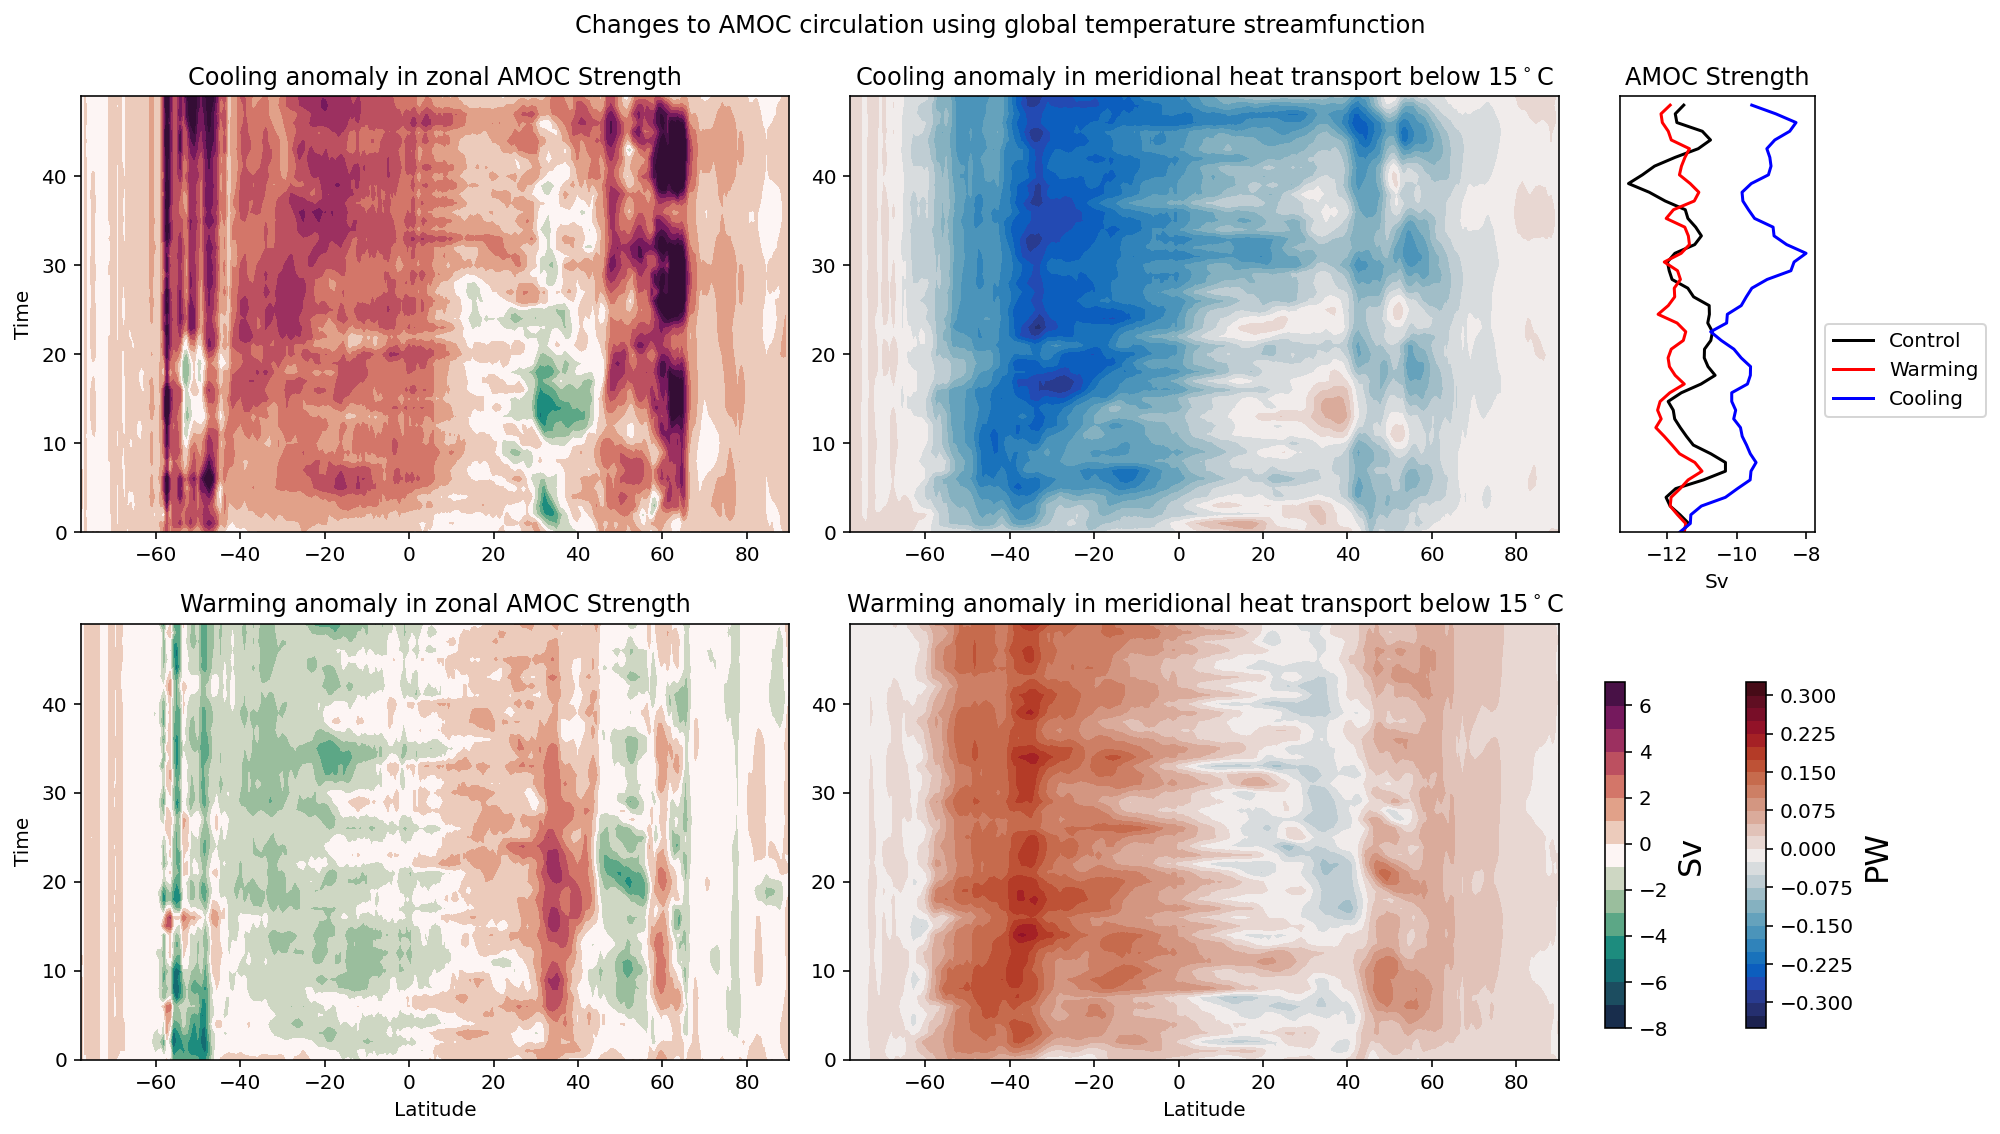

In [11]:
psi_avg_cont,A_I_cont = heatfuncforamoc('Control',False, indo_sector_mask)
psi_avg_warm,A_I_warm = heatfuncforamoc('Warming',False, indo_sector_mask)
psi_avg_warm = psi_avg_warm.sel(neutral=slice(-5,15)).min('neutral').groupby('time.year').mean('time')
psi_avg_cont = psi_avg_cont.sel(neutral=slice(-5,15)).min('neutral').mean('time')
clev = np.arange(-8,8,1)
psi_avg_cont,A_I_cont = heatfuncforamoc('Control',False, indo_sector_mask)
psi_avg_cool,A_I_cool = heatfuncforamoc('Cooling',False, indo_sector_mask)
psi_avg_cool = psi_avg_cool.sel(neutral=slice(-5,15)).min('neutral').groupby('time.year').mean('time')
psi_avg_cont = psi_avg_cont.sel(neutral=slice(-5,15)).min('neutral').mean('time')
clev2 = np.arange(-0.35,0.35,0.025)

heatfuncwarm = A_I_warm.sel(neutral=15, method = 'nearest').groupby('time.year').mean('time')-A_I_cont.sel(neutral=15, method = 'nearest').mean('time')
heatfunccool = A_I_cool.sel(neutral=15, method = 'nearest').groupby('time.year').mean('time')-A_I_cont.sel(neutral=15, method = 'nearest').mean('time')

fig3 = plt.figure(figsize = (14,8))#constrained_layout=True,
plt.suptitle('Changes to AMOC circulation using global temperature streamfunction')
gs = fig3.add_gridspec(2, 7)
f3_ax1 = fig3.add_subplot(gs[0,0:3])
f3_ax1.set_title('Cooling anomaly in zonal AMOC Strength')
f3_ax1.set_ylabel('Time')
f3_ax1.contourf((psi_avg_cool-psi_avg_cont).grid_yu_ocean,(psi_avg_cool-psi_avg_cont).year-2900,(psi_avg_cool-psi_avg_cont), levels = clev,extend='both', cmap = cm.cm.curl)

f3_ax2 = fig3.add_subplot(gs[0,3:6])
f3_ax2.contourf(heatfunccool.grid_yu_ocean,heatfunccool.year-2900,heatfunccool, levels = clev2, cmap = cm.cm.balance)
f3_ax2.set_title('Cooling anomaly in meridional heat transport below 15$^\circ$C')

f3_ax3 = fig3.add_subplot(gs[ 0,6])
keys = ['Control','Warming','Cooling']# 'Warming x2','Cooling x2']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2900-01-01'
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_nrho',session,start_time = start_time,ncfile = 'ocean.nc' )
    psi_amoc = (var*atlantic_sector_mask).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('neutral') - psi_amoc.sum('neutral')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time)
        psi_amoc_gm = (var2*atlantic_sector_mask).sum('grid_xt_ocean')*1.0e-9
        var3 = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time)
        psi_amoc_submeso = (var3*atlantic_sector_mask).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm + psi_amoc_submeso
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(neutral=slice(None,15)).min('neutral').min('grid_yu_ocean').groupby('time.year').mean('time')#(time='Y').mean()
    psi_amoc_sum.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey], ax = f3_ax3, y="year")
plt.legend(bbox_to_anchor=(1, 0.5))
f3_ax3.set_title('AMOC Strength')
f3_ax3.set_ylim(2900,2950)

#f3_ax3.set_ylabel('')
f3_ax3.axes.yaxis.set_visible(False)
f3_ax3.set_xlabel('Sv')


f3_ax4 = fig3.add_subplot(gs[ 1,0:3])
CS2 = f3_ax4.contourf((psi_avg_warm-psi_avg_cont).grid_yu_ocean,(psi_avg_warm-psi_avg_cont).year-2900,(psi_avg_warm-psi_avg_cont), levels = clev, cmap = cm.cm.curl)
f3_ax4.set_ylabel('Time')
f3_ax4.set_xlabel('Latitude')
f3_ax4.set_title('Warming anomaly in zonal AMOC Strength')

f3_ax5 = fig3.add_subplot(gs[1,3:6])
CS = f3_ax5.contourf(heatfuncwarm.grid_yu_ocean,heatfuncwarm.year-2900,heatfuncwarm, levels = clev2, cmap = cm.cm.balance)
f3_ax5.set_title('Warming anomaly in meridional heat transport below 15$^\circ$C')
f3_ax5.set_xlabel('Latitude')

cb_ax = fig3.add_axes([0.87, 0.1, 0.01, 0.3])
cbar = fig3.colorbar(CS, cax=cb_ax)
cbar.ax.set_ylabel('PW', fontsize = 16)

cb_ax = fig3.add_axes([0.8, 0.1, 0.01, 0.3])
cbar = fig3.colorbar(CS2, cax=cb_ax)
cbar.ax.set_ylabel('Sv', fontsize = 16)

plt.tight_layout()
#plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)
#plt.savefig('globalhovmoller',dpi = 600)

1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPcoolhumid


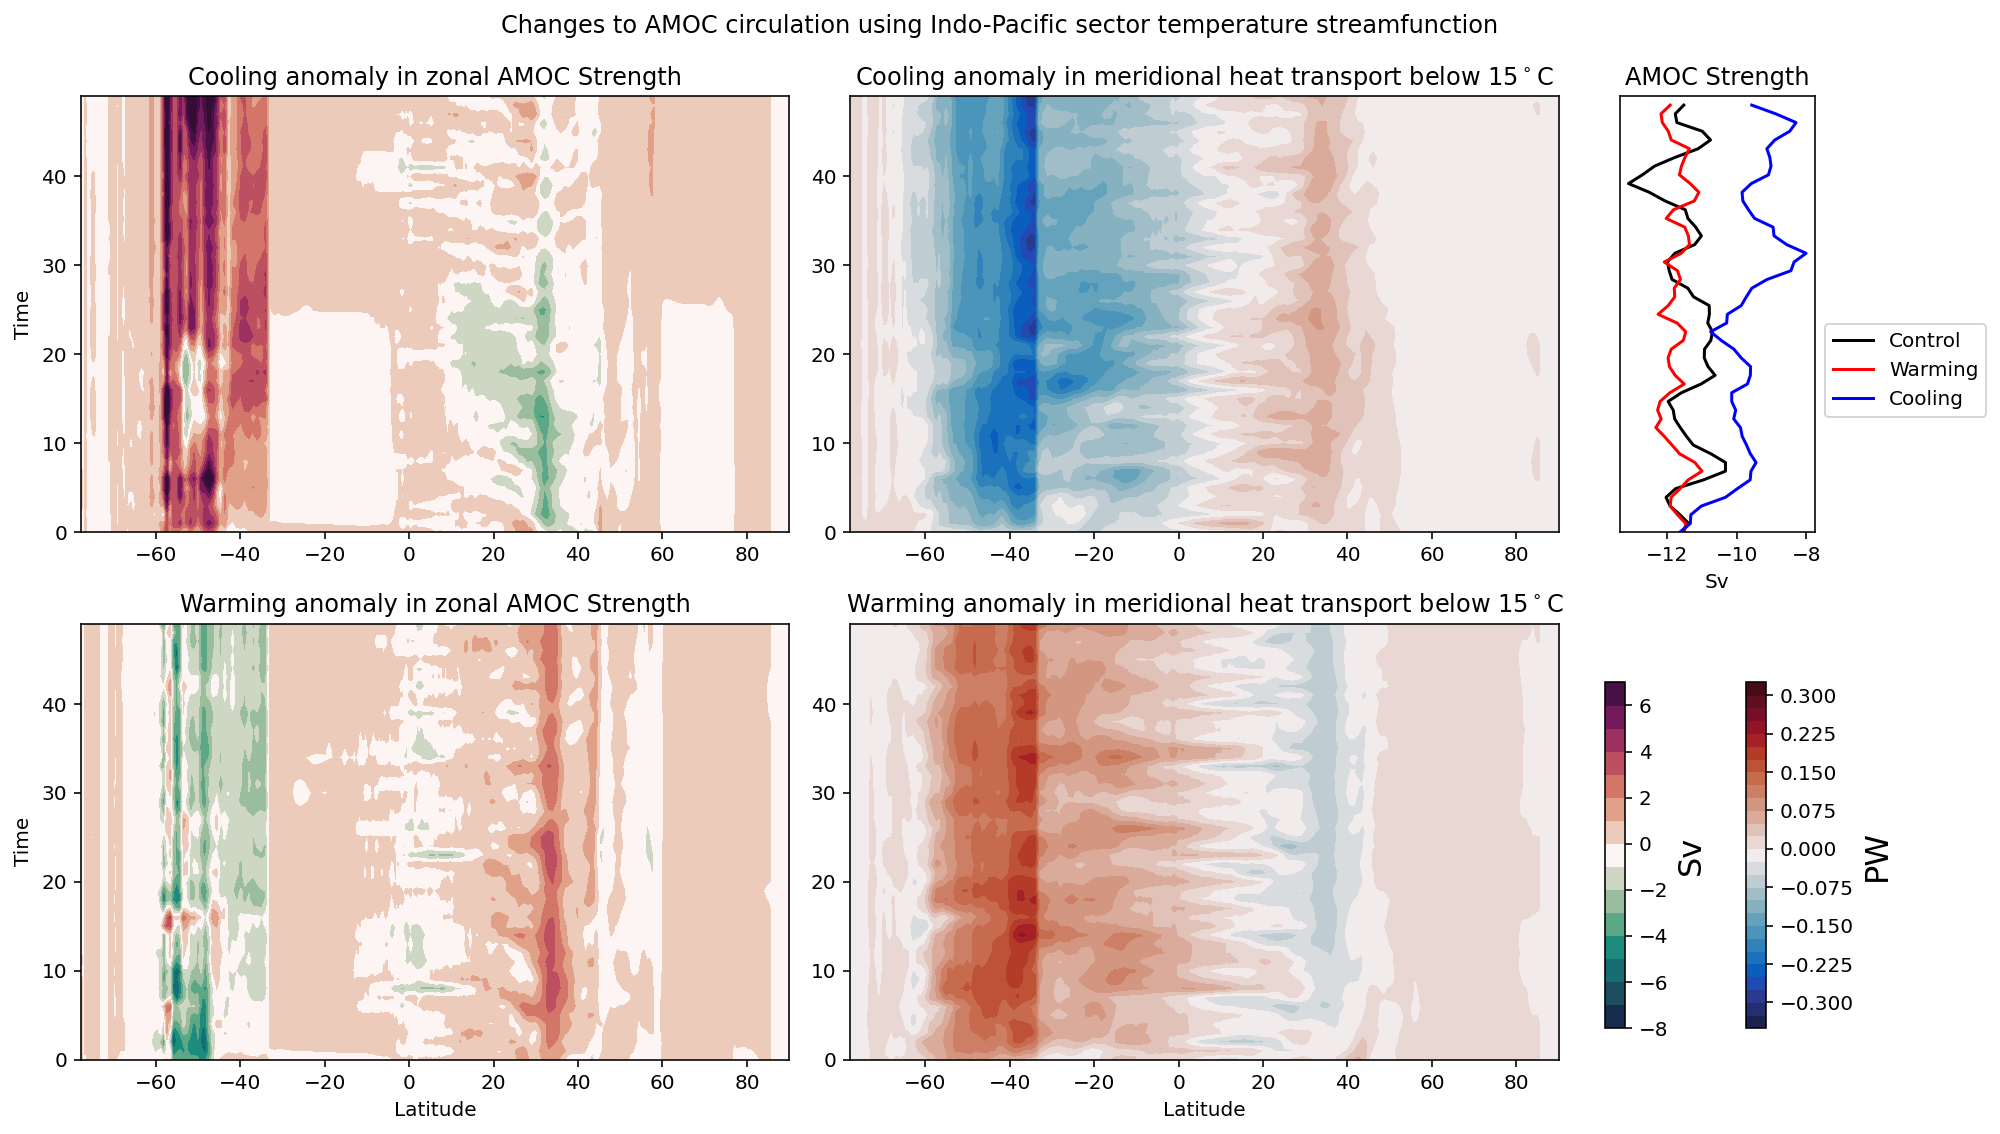

In [12]:
psi_avg_cont,A_I_cont = heatfuncforamoc('Control',True, indo_sector_mask)
psi_avg_warm,A_I_warm = heatfuncforamoc('Warming',True, indo_sector_mask)
psi_avg_warm = psi_avg_warm.sel(neutral=slice(-5,15)).min('neutral').groupby('time.year').mean('time')
psi_avg_cont = psi_avg_cont.sel(neutral=slice(-5,15)).min('neutral').mean('time')
clev = np.arange(-8,8,1)
psi_avg_cont,A_I_cont = heatfuncforamoc('Control',True, indo_sector_mask)
psi_avg_cool,A_I_cool = heatfuncforamoc('Cooling',True, indo_sector_mask)
psi_avg_cool = psi_avg_cool.sel(neutral=slice(-5,15)).min('neutral').groupby('time.year').mean('time')
psi_avg_cont = psi_avg_cont.sel(neutral=slice(-5,15)).min('neutral').mean('time')
clev2 = np.arange(-0.35,0.35,0.025)

heatfuncwarm = A_I_warm.sel(neutral=15, method = 'nearest').groupby('time.year').mean('time')-A_I_cont.sel(neutral=15, method = 'nearest').mean('time')
heatfunccool = A_I_cool.sel(neutral=15, method = 'nearest').groupby('time.year').mean('time')-A_I_cont.sel(neutral=15, method = 'nearest').mean('time')

fig3 = plt.figure(figsize = (14,8))#constrained_layout=True,
plt.suptitle('Changes to AMOC circulation using Indo-Pacific sector temperature streamfunction')
gs = fig3.add_gridspec(2, 7)
f3_ax1 = fig3.add_subplot(gs[0,0:3])
f3_ax1.set_title('Cooling anomaly in zonal AMOC Strength')
f3_ax1.set_ylabel('Time')
f3_ax1.contourf((psi_avg_cool-psi_avg_cont).grid_yu_ocean,(psi_avg_cool-psi_avg_cont).year-2900,(psi_avg_cool-psi_avg_cont), levels = clev,extend='both', cmap = cm.cm.curl)

f3_ax2 = fig3.add_subplot(gs[0,3:6])
f3_ax2.contourf(heatfunccool.grid_yu_ocean,heatfunccool.year-2900,heatfunccool, levels = clev2, cmap = cm.cm.balance)
f3_ax2.set_title('Cooling anomaly in meridional heat transport below 15$^\circ$C')

f3_ax3 = fig3.add_subplot(gs[ 0,6])
keys = ['Control','Warming','Cooling']# 'Warming x2','Cooling x2']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2900-01-01'
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_nrho',session,start_time = start_time,ncfile = 'ocean.nc' )
    psi_amoc = (var*atlantic_sector_mask).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('neutral') - psi_amoc.sum('neutral')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time)
        psi_amoc_gm = (var2*atlantic_sector_mask).sum('grid_xt_ocean')*1.0e-9
        var3 = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time)
        psi_amoc_submeso = (var3*atlantic_sector_mask).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm + psi_amoc_submeso
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(neutral=slice(None,15)).min('neutral').min('grid_yu_ocean').groupby('time.year').mean('time')#(time='Y').mean()
    psi_amoc_sum.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey], ax = f3_ax3, y="year")
plt.legend(bbox_to_anchor=(1, 0.5))
f3_ax3.set_title('AMOC Strength')
f3_ax3.set_ylim(2900,2950)

#f3_ax3.set_ylabel('')
f3_ax3.axes.yaxis.set_visible(False)
f3_ax3.set_xlabel('Sv')


f3_ax4 = fig3.add_subplot(gs[ 1,0:3])
CS2 = f3_ax4.contourf((psi_avg_warm-psi_avg_cont).grid_yu_ocean,(psi_avg_warm-psi_avg_cont).year-2900,(psi_avg_warm-psi_avg_cont), levels = clev, cmap = cm.cm.curl)
f3_ax4.set_ylabel('Time')
f3_ax4.set_xlabel('Latitude')
f3_ax4.set_title('Warming anomaly in zonal AMOC Strength')

f3_ax5 = fig3.add_subplot(gs[1,3:6])
CS = f3_ax5.contourf(heatfuncwarm.grid_yu_ocean,heatfuncwarm.year-2900,heatfuncwarm, levels = clev2, cmap = cm.cm.balance)
f3_ax5.set_title('Warming anomaly in meridional heat transport below 15$^\circ$C')
f3_ax5.set_xlabel('Latitude')

cb_ax = fig3.add_axes([0.87, 0.1, 0.01, 0.3])
cbar = fig3.colorbar(CS, cax=cb_ax)
cbar.ax.set_ylabel('PW', fontsize = 16)

cb_ax = fig3.add_axes([0.8, 0.1, 0.01, 0.3])
cbar = fig3.colorbar(CS2, cax=cb_ax)
cbar.ax.set_ylabel('Sv', fontsize = 16)

plt.tight_layout()
#plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)
#plt.savefig('pacifichovmoller',dpi = 600)

1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPcoolhumid


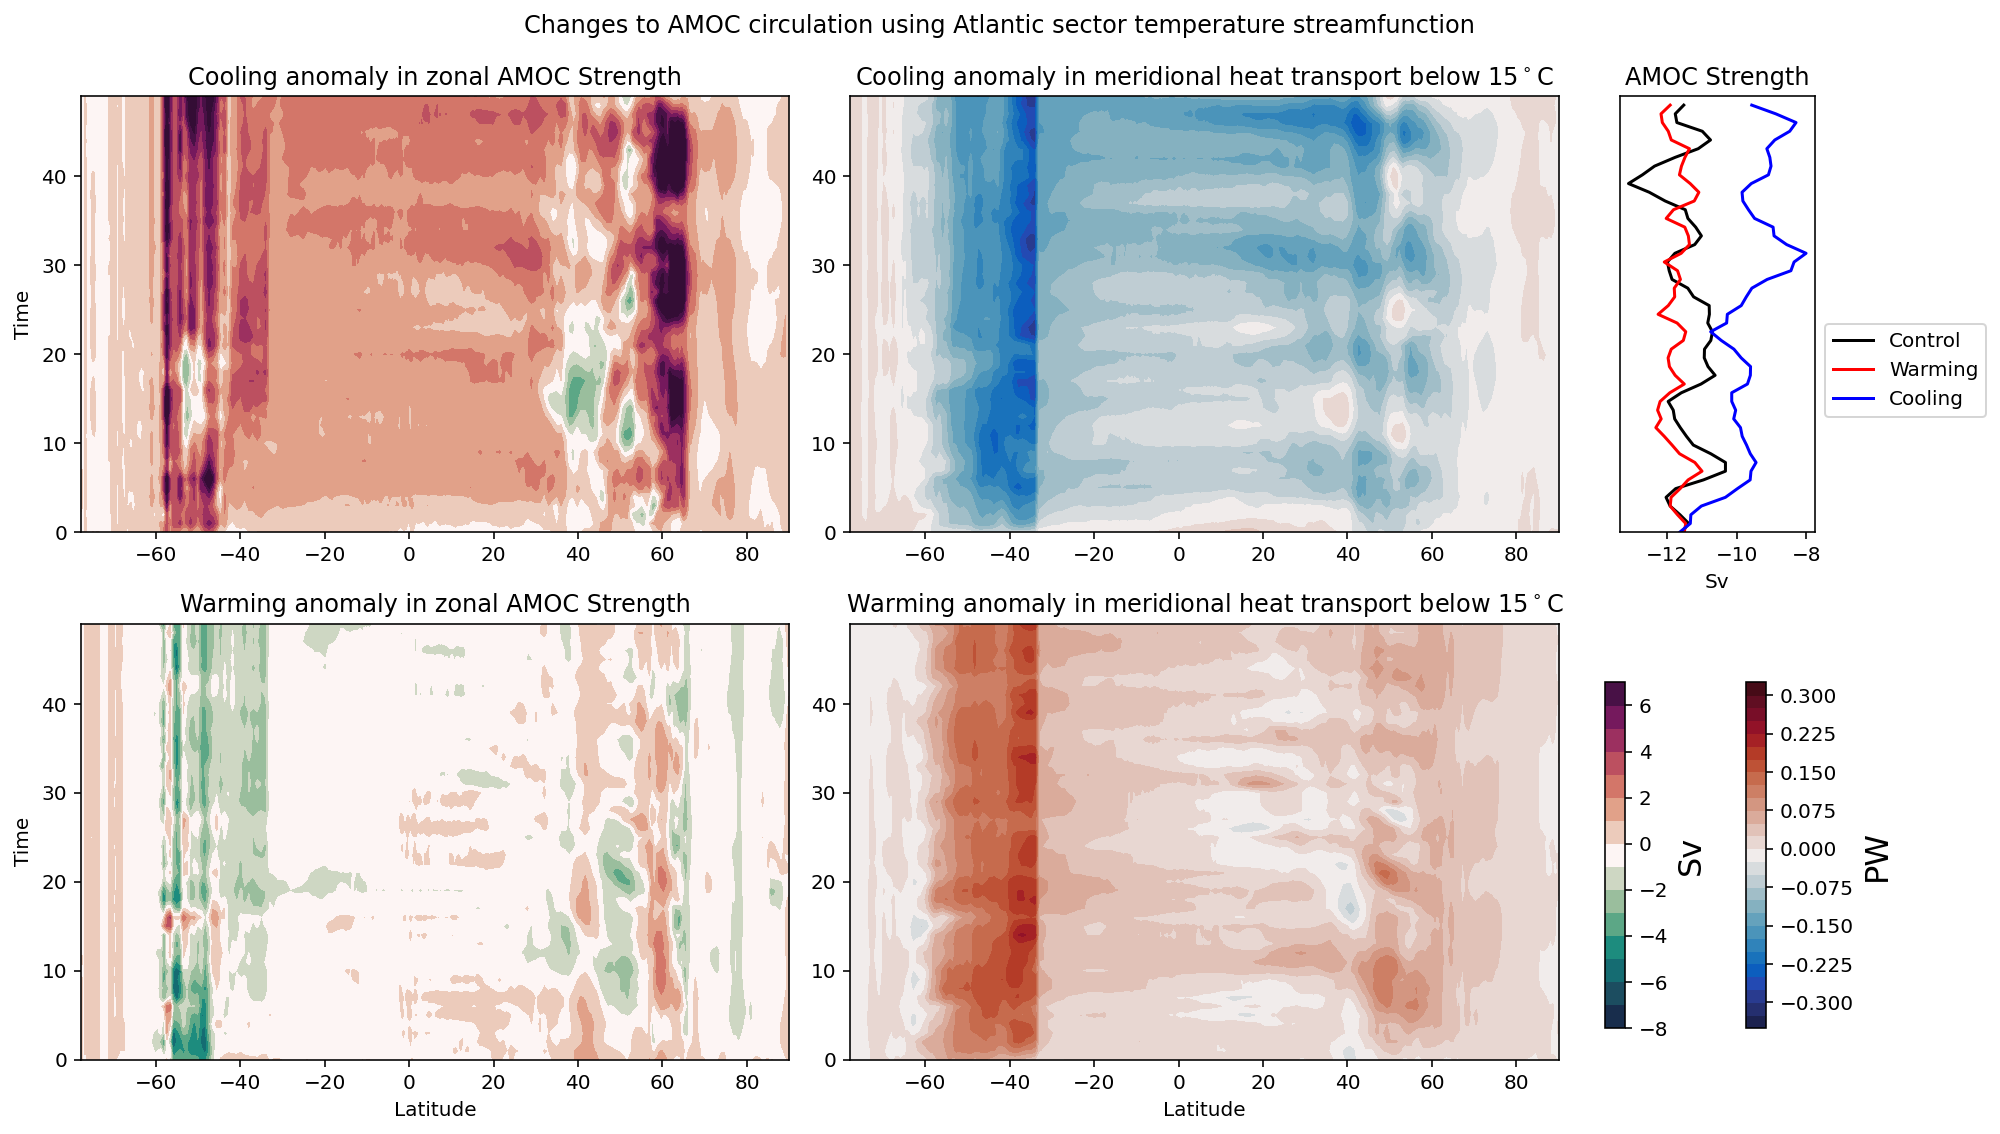

In [13]:
psi_avg_cont,A_I_cont = heatfuncforamoc('Control',True, atlantic_sector_mask)
psi_avg_warm,A_I_warm = heatfuncforamoc('Warming',True, atlantic_sector_mask)
psi_avg_warm = psi_avg_warm.sel(neutral=slice(-5,15)).min('neutral').groupby('time.year').mean('time')
psi_avg_cont = psi_avg_cont.sel(neutral=slice(-5,15)).min('neutral').mean('time')
clev = np.arange(-8,8,1)
psi_avg_cont,A_I_cont = heatfuncforamoc('Control',True, atlantic_sector_mask)
psi_avg_cool,A_I_cool = heatfuncforamoc('Cooling',True, atlantic_sector_mask)
psi_avg_cool = psi_avg_cool.sel(neutral=slice(-5,15)).min('neutral').groupby('time.year').mean('time')
psi_avg_cont = psi_avg_cont.sel(neutral=slice(-5,15)).min('neutral').mean('time')
clev2 = np.arange(-0.35,0.35,0.025)

heatfuncwarm = A_I_warm.sel(neutral=15, method = 'nearest').groupby('time.year').mean('time')-A_I_cont.sel(neutral=15, method = 'nearest').mean('time')
heatfunccool = A_I_cool.sel(neutral=15, method = 'nearest').groupby('time.year').mean('time')-A_I_cont.sel(neutral=15, method = 'nearest').mean('time')

fig3 = plt.figure(figsize = (14,8))#constrained_layout=True,
plt.suptitle('Changes to AMOC circulation using Atlantic sector temperature streamfunction')
gs = fig3.add_gridspec(2, 7)
f3_ax1 = fig3.add_subplot(gs[0,0:3])
f3_ax1.set_title('Cooling anomaly in zonal AMOC Strength')
f3_ax1.set_ylabel('Time')
f3_ax1.contourf((psi_avg_cool-psi_avg_cont).grid_yu_ocean,(psi_avg_cool-psi_avg_cont).year-2900,(psi_avg_cool-psi_avg_cont), levels = clev,extend='both', cmap = cm.cm.curl)

f3_ax2 = fig3.add_subplot(gs[0,3:6])
f3_ax2.contourf(heatfunccool.grid_yu_ocean,heatfunccool.year-2900,heatfunccool, levels = clev2, cmap = cm.cm.balance)
f3_ax2.set_title('Cooling anomaly in meridional heat transport below 15$^\circ$C')

f3_ax3 = fig3.add_subplot(gs[ 0,6])
keys = ['Control','Warming','Cooling']# 'Warming x2','Cooling x2']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2900-01-01'
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_nrho',session,start_time = start_time,ncfile = 'ocean.nc' )
    psi_amoc = (var*atlantic_sector_mask).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('neutral') - psi_amoc.sum('neutral')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time)
        psi_amoc_gm = (var2*atlantic_sector_mask).sum('grid_xt_ocean')*1.0e-9
        var3 = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time)
        psi_amoc_submeso = (var3*atlantic_sector_mask).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm + psi_amoc_submeso
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(neutral=slice(None,15)).min('neutral').min('grid_yu_ocean').groupby('time.year').mean('time')#(time='Y').mean()
    psi_amoc_sum.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey], ax = f3_ax3, y="year")
plt.legend(bbox_to_anchor=(1, 0.5))
f3_ax3.set_title('AMOC Strength')
f3_ax3.set_ylim(2900,2950)

#f3_ax3.set_ylabel('')
f3_ax3.axes.yaxis.set_visible(False)
f3_ax3.set_xlabel('Sv')


f3_ax4 = fig3.add_subplot(gs[ 1,0:3])
CS2 = f3_ax4.contourf((psi_avg_warm-psi_avg_cont).grid_yu_ocean,(psi_avg_warm-psi_avg_cont).year-2900,(psi_avg_warm-psi_avg_cont), levels = clev, cmap = cm.cm.curl)
f3_ax4.set_ylabel('Time')
f3_ax4.set_xlabel('Latitude')
f3_ax4.set_title('Warming anomaly in zonal AMOC Strength')

f3_ax5 = fig3.add_subplot(gs[1,3:6])
CS = f3_ax5.contourf(heatfuncwarm.grid_yu_ocean,heatfuncwarm.year-2900,heatfuncwarm, levels = clev2, cmap = cm.cm.balance)
f3_ax5.set_title('Warming anomaly in meridional heat transport below 15$^\circ$C')
f3_ax5.set_xlabel('Latitude')

cb_ax = fig3.add_axes([0.87, 0.1, 0.01, 0.3])
cbar = fig3.colorbar(CS, cax=cb_ax)
cbar.ax.set_ylabel('PW', fontsize = 16)

cb_ax = fig3.add_axes([0.8, 0.1, 0.01, 0.3])
cbar = fig3.colorbar(CS2, cax=cb_ax)
cbar.ax.set_ylabel('Sv', fontsize = 16)

plt.tight_layout()
#plt.subplots_adjust(top=0.85, right = 0.85, hspace = 0.25)
#plt.savefig('atlantichovmoller',dpi = 600)